# RLC Circuit Neural Network

This notebook contains the code to reproduce the plots demonstrating a neural network applied to an RLC circuit problem.

## Problem Overview

The example problem we solve here is the source-free underdamped series RLC  circuit described by the following differential equation based on Kirchhoff's voltage law:
$$
L \dfrac{d^2 I}{d t^2} + R \dfrac{d I}{d t} + \dfrac{1}{C}I = 0~,
$$
with the initial conditions
$$
I(0) = I_0~~,~~\dfrac{d I}{d t}(0) = 0~.
$$

In the underdamped state, the following conditions hold:
$$
\alpha < \omega_0~,~~~~~\mathrm{with}~~\alpha = \dfrac{R}{2L}~,~\omega_0 = \dfrac{1}{\sqrt{LC}}~.
$$
This leads to the exact solution for the current across the capacitor:
$$
I(t) = I_0 \cdot e^{-\alpha t} \cdot \sin(\omega_d t + \phi)~,~~~~~\mathrm{with}~~\omega_d = \sqrt{\omega_0^2 - \alpha^2}~.
$$

In [2]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def rlc_circuit(R, L, C, t):
    """Defines the analytical solution to the underdamped RLC circuit problem.
    The current across the capacitor I(t) = I0 * exp(-at) * sin(ω_d * t + φ).
    Here, a is the damping ratio and ω_d is the damped natural frequency."""
    a = R / (2 * L)
    ω_0 = 1 / np.sqrt(L * C)
    ω_d = np.sqrt(ω_0**2 - a**2)
    I0 = 1
    phi = np.pi / 2
    
    return I0 * torch.exp(-a * t) * torch.sin(ω_d * t + phi)


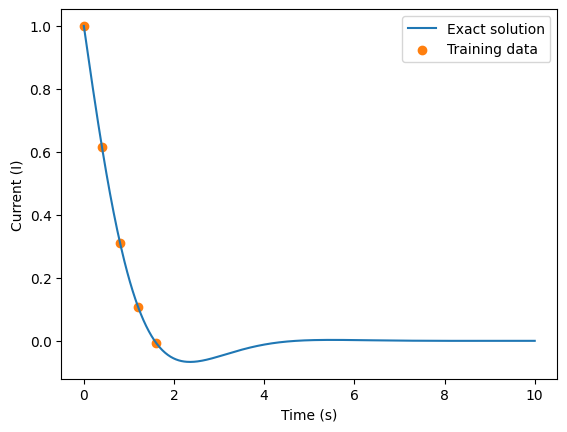

In [4]:
# RLC circuit parameters
R, L, C = 2.0, 1.0, 0.5

# Generate dataset
t = torch.linspace(0, 10, 500).view(-1, 1)
I = rlc_circuit(R, L, C, t).view(-1, 1)

# Training data
t_data = t[0:100:20]
I_data = I[0:100:20]

plt.figure()
plt.plot(t, I, label="Exact solution")
plt.scatter(t_data, I_data, color="tab:orange", label="Training data")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Current (I)")
plt.show()

In [5]:
class FCN(nn.Module):
    "Defines a fully connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [6]:
def plot_result(t, I, t_data, I_data, Ih, step, tp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(t,I, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t,Ih, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(t_data, I_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if tp is not None:
        plt.scatter(tp, -0*torch.ones_like(tp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    plt.legend()
    plt.text(1.065,0.7,"Training step: %i"% step,fontsize="xx-large",color="k")
    plt.xlabel("Time (s)")
    plt.ylabel("Current (I)")
    plt.title("RLC Circuit Current Response")
    plt.axis("off")

## With NN

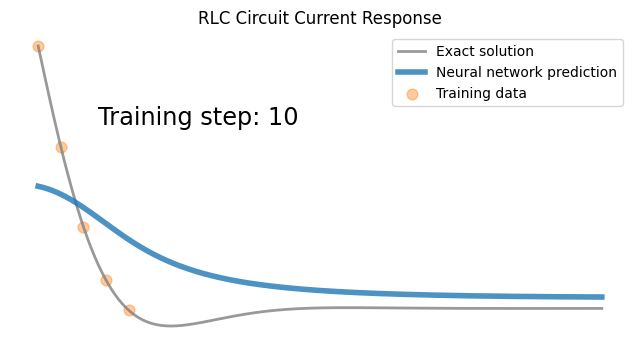

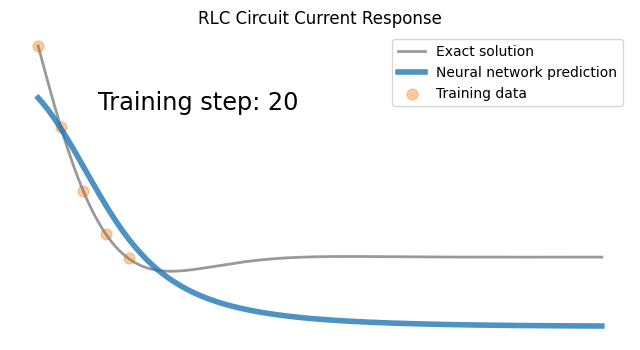

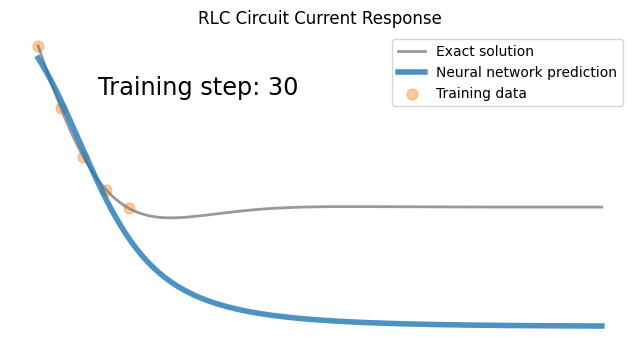

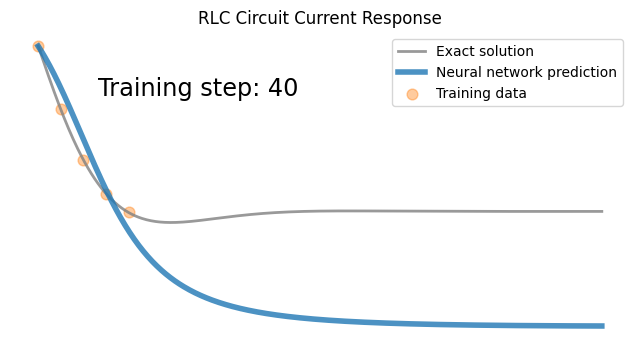

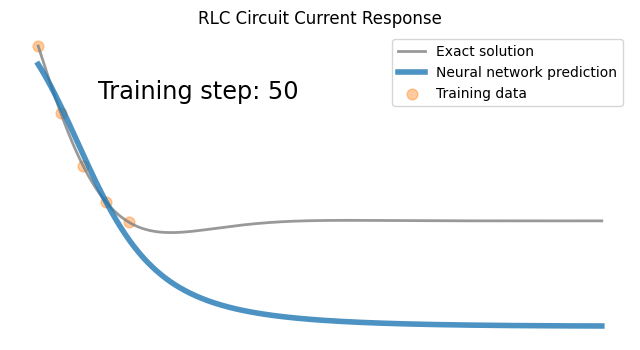

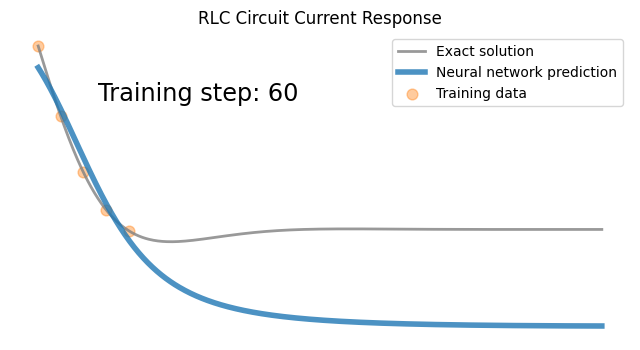

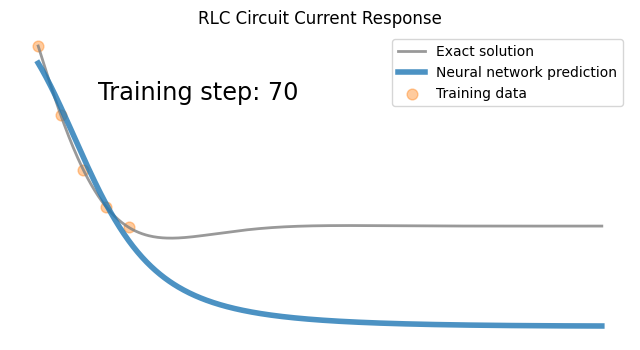

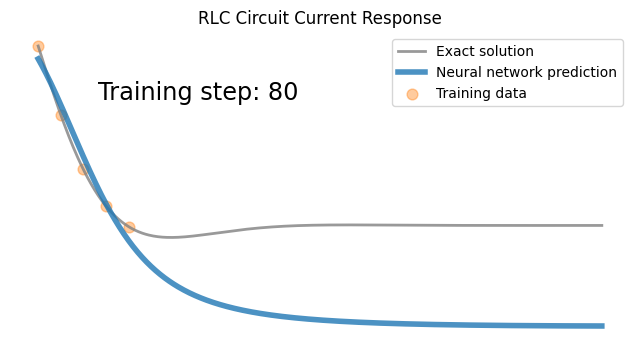

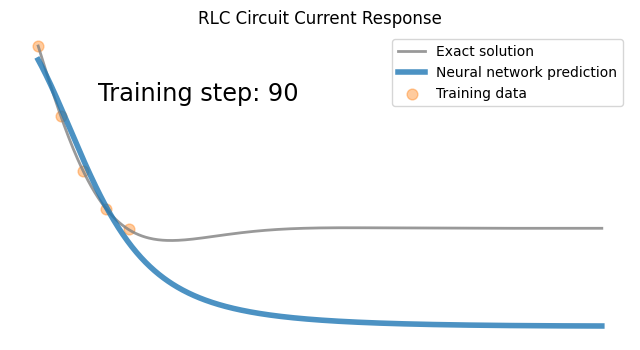

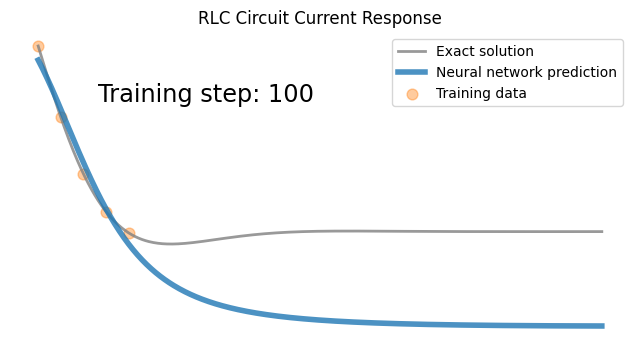

In [7]:
torch.manual_seed(123)

model = FCN(1, 1, 32, 3)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(100):
    optimizer.zero_grad()
    Ih = model(t_data)
    loss = loss_fn(Ih, I_data)  
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0: 
        Ih_full = model(t).detach()  
        plot_result(t, I, t_data, I_data, Ih_full, i+1)
        plt.show()

## With PINN
 - We also include physics loss to the loss function
 - We are evaluting the physics loss at 30 points uniformly spaced over the problem domain, $([0,10])$.

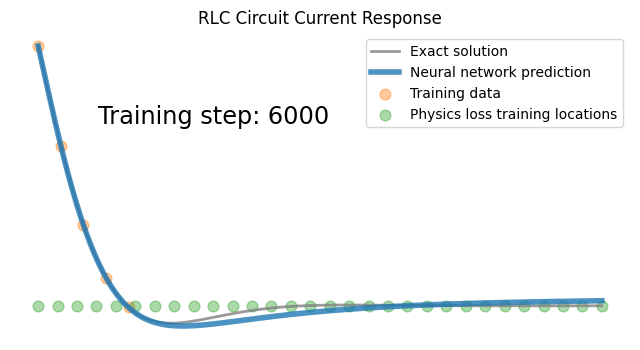

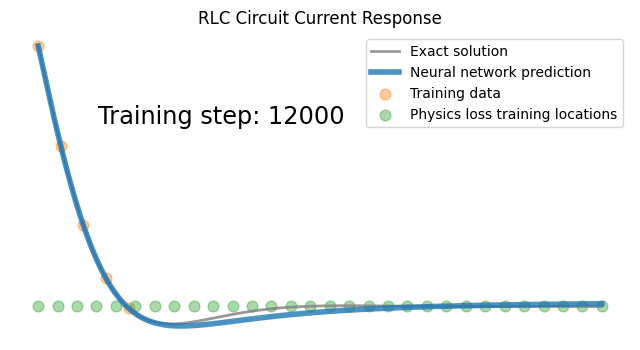

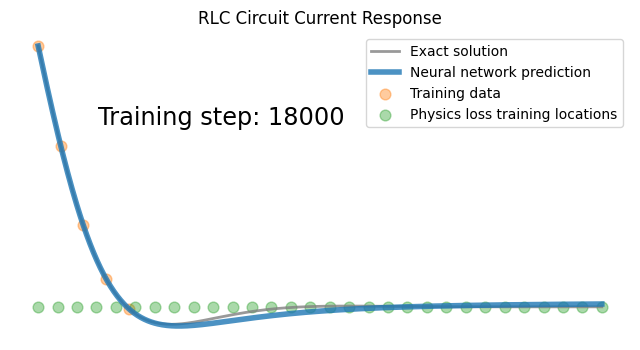

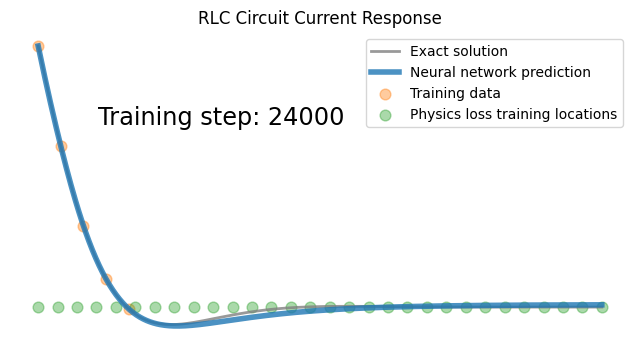

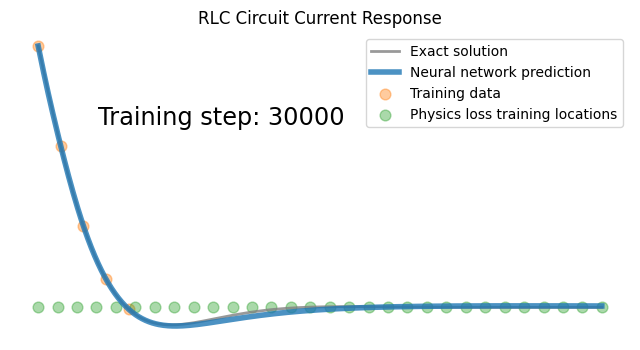

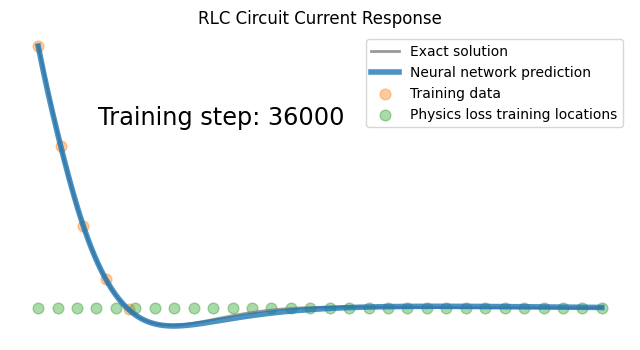

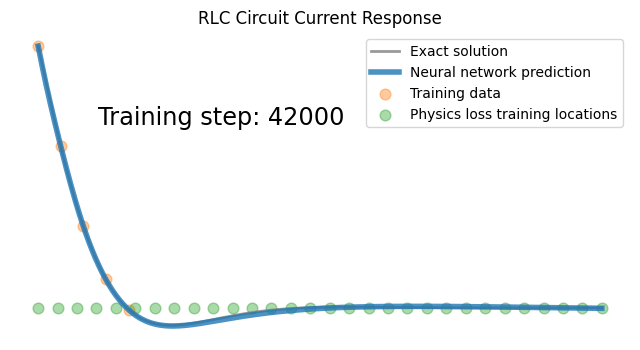

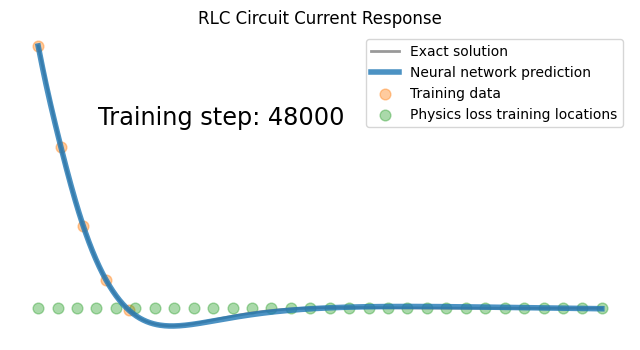

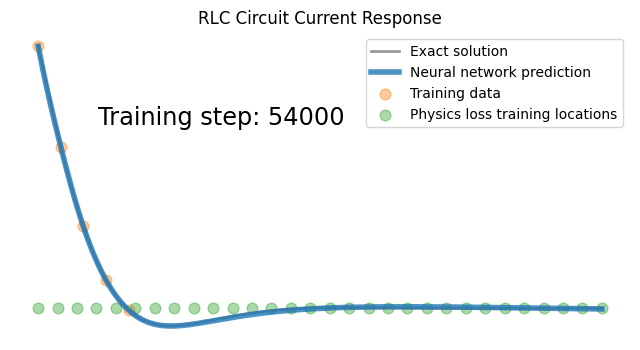

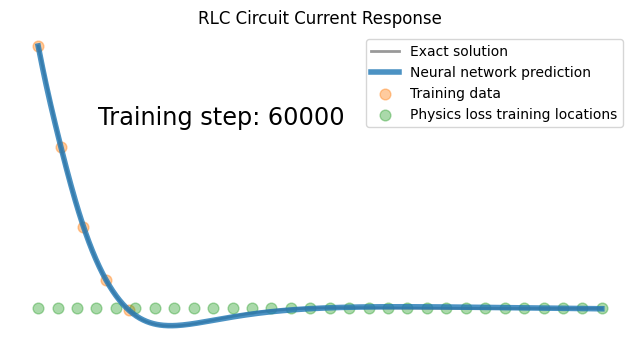

In [8]:
t_physics = torch.linspace(0, 10, 30).view(-1,1).requires_grad_(True)  # Sample locations over the problem domain

torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(60000):
    optimizer.zero_grad()
    
    # Compute the "data loss" (Same as NN)
    Ih = model(t_data) 
    loss1 = loss_fn(Ih, I_data)  
    
    # Compute the "physics loss" for RLC circuit
    Ihp = model(t_physics)
    dx  = torch.autograd.grad(Ihp, t_physics, torch.ones_like(Ihp), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx,  t_physics, torch.ones_like(dx), create_graph=True)[0]

    physics = L * dx2 + R * dx + (1 / C) * Ihp
    loss2 = (1e-4) * torch.mean(physics**2)  # Scaled physics loss
    
    loss = loss1 + loss2  
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 6000 == 0:
        Ih = model(t).detach()
        tp = t_physics.detach()
        plot_result(t, I, t_data, I_data, Ih, i+1, tp)
        plt.show()
            


# Comparison between NN and PINN

1. Accuracy:
    - Standard NN:
      - The standard neural network fits the training data well but tends to overfit the limited training points.
      - On unseen time intervals, the model may deviate significantly from the exact solution because it's only learning from the available data without understanding the underlying physics.
    
      **Inference**: NN is more prone to error in regions where data is sparse or unavailable, particularly where oscillations change more rapidly.
     
    - PINN:
      - The PINN incorporates the RLC circuit's differential equation into the loss function, which forces the network to respect the physical laws governing the system.
      - As a result, the PINN approximates the exact solution more accurately, even in regions where training data is scarce or entirely absent.
        
      **Inference**: The PINN significantly improves accuracy in predicting the current response over time, especially in the underdamped oscillatory behavior.

2. Generalization:
    - Standard NN:
      - The standard NN struggles to generalize well outside the training data, especially in regions of rapid oscillations. The model lacks an understanding of the physical behavior that drives the current oscillations and damping.
        
      **Inference**: The standard NN overfits to the training points and generalizes poorly, especially in the tail end of the time interval.

    - PINN:
      - The PINN generalizes well even in unseen regions, as the physics-based loss helps it learn the correct oscillatory and damping behavior of the system. The differential equation serves as an implicit "regularizer," making the model more robust.
        
      **Inference**: The PINN generalizes effectively beyond the training data, making it a better approach for physical systems with known governing equations.

3. Convergence Speed:
    - Standard NN:
      - The standard NN can converge quickly when optimizing solely on the data loss. However, its performance plateaus when the training data is limited, as it doesn't incorporate any additional knowledge about the system.
        
      **Inference**: The NN may reach a point where it no longer improves, especially if the training data is sparse or limited in scope.

    - PINN:
      - The PINN generally takes longer to converge due to the added complexity of optimizing both data and physics losses. However, it eventually reaches a more accurate and stable solution that respects the system's dynamics.
        
      **Inference**: Although PINN takes more time to train, its final result is much more aligned with the true behavior of the RLC circuit.

## Final Conclusion:
The PINN approach outperforms the standard neural network in terms of accuracy and generalization. While it takes longer to train, the PINN learns a more physically consistent solution and performs significantly better in regions where the training data is sparse. This is because the inclusion of the governing differential equation in the training process allows the PINN to respect the underlying physics of the problem, leading to more reliable predictions.

For tasks involving physical systems like the RLC circuit, PINNs are a far superior choice compared to standard data-driven neural networks.